/home/takato/.cache/pypoetry/virtualenvs/fuzzy-truck-py3.7/lib/python3.7/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


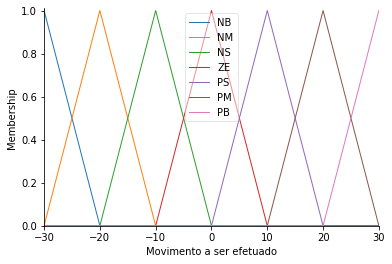

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

import matplotlib
%matplotlib inline 

x = ctrl.Antecedent(np.arange(0, 11, 1), 'Posição em X')
y = ctrl.Antecedent(np.arange(0, 11, 1), 'Posição em Y')
angle = ctrl.Antecedent(np.arange(0, 180, 1), 'Angulo do caminhão')

movement = ctrl.Consequent(np.arange(-30, 31, 1), 'Movimento a ser efetuado')

angle.automf(7, 
            names=[
             'large_below_90',
             'medium_below_90',
             'small_below_90',
             'at_90',
             'small_above_90',
             'medium_above_90',
             'large_above_90',
            ])

x.automf(5,
        names=[
            'left_big',
            'left_medium',
            'centered',
            'right_medium',
            'right_big',
        ])

movement.automf(7, 
               names=[
                'NB', # negative big change',
                'NM', # negative medium change',
                'NS', # negative small change',
                'ZE', # zero (no change)',
                'PS', # positive small change',
                'PM', # positive medium change',
                'PB', # positive big change',
               ])

movement.view()

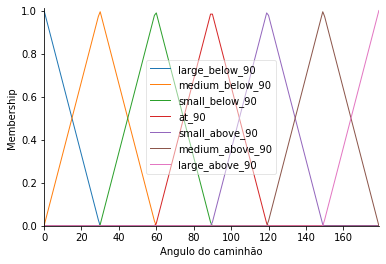

In [4]:
angle.view()

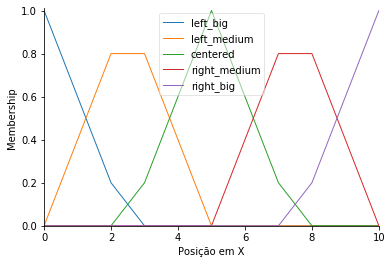

In [5]:
x.view()

In [2]:
import socket

from loguru import logger

class Driver:
    '''
        Driver for interpreting signals from application and process the
        next movement
    '''

    def __init__(self, host: str, port: int):
        '''
        Parameters 
        
        ----------
        host : string
            Hostname where application is listening
        port : int
            Port where host will be listning
        '''
        
        self.host = host
        self.port = port
        
        self._client = socket.socket(socket.AF_INET, 
                                    socket.SOCK_STREAM)
        ip = socket.gethostbyname(host)
        address = (ip, port)
        
        try:
            self._client.connect(address)
        except ConnectionRefusedError:
            logger.error('Failed to connect to application. Restart simulation.')
            raise

        self.upper_limit = 1
        self.lower_limit = -1
        
        self._setup_fuzzy_variables()
        self._setup_fuzzy_rules()
        self._setup_fuzzy_controller()
        
        self.done = False
    
    def _setup_fuzzy_variables(self):
        '''
        Configure the fuzzy logic, variables on object to be used
        by _setup_fuzzy_rules and _setup_fuzzy_controller
        '''
        
        self.x = ctrl.Antecedent(np.arange(0, 11, 1), 'x_position')
        self.angle = ctrl.Antecedent(np.arange(0, 180, 1), 'truck_angle')

        self.movement = ctrl.Consequent(np.arange(-30, 31, 1), 'movement')

        self.angle.automf(7, 
                    names=[
                     'large_below_90',
                     'medium_below_90',
                     'small_below_90',
                     'at_90',
                     'small_above_90',
                     'medium_above_90',
                     'large_above_90',
                    ])

        self.x.automf(5,
                names=[
                    'left_big',
                    'left_medium',
                    'centered',
                    'right_medium',
                    'right_big',
                ])

        self.movement.automf(7, 
                       names=[
                        'NB', # negative big change',
                        'NM', # negative medium change',
                        'NS', # negative small change',
                        'ZE', # zero (no change)',
                        'PS', # positive small change',
                        'PM', # positive medium change',
                        'PB', # positive big change',
                       ])

    def _setup_fuzzy_rules(self):
        '''
        Setup fuzzy rules, rules inserted  on object
        to be used by _setup_fuzzy_controller
        '''
        self._rules = [
            # Large Below 90
            ctrl.Rule(self.angle['large_below_90'] & self.x['left_big'], self.movement['PB']),
            ctrl.Rule(self.angle['large_below_90'] & self.x['left_medium'], self.movement['PB']),
            ctrl.Rule(self.angle['large_below_90'] & self.x['centered'], self.movement['PB']),
            ctrl.Rule(self.angle['large_below_90'] & self.x['right_medium'], self.movement['PB']),
            ctrl.Rule(self.angle['large_below_90'] & self.x['right_big'], self.movement['PM']),
            # Medium Below 90
            ctrl.Rule(self.angle['medium_below_90'] & self.x['left_big'], self.movement['PB']),
            ctrl.Rule(self.angle['medium_below_90'] & self.x['left_medium'], self.movement['PB']),
            ctrl.Rule(self.angle['medium_below_90'] & self.x['centered'], self.movement['PM']),
            ctrl.Rule(self.angle['medium_below_90'] & self.x['right_medium'], self.movement['PM']),
            ctrl.Rule(self.angle['medium_below_90'] & self.x['right_big'], self.movement['PS']),
            # Small Below 90
            ctrl.Rule(self.angle['small_below_90'] & self.x['left_big'], self.movement['PB']),
            ctrl.Rule(self.angle['small_below_90'] & self.x['left_medium'], self.movement['PM']),
            ctrl.Rule(self.angle['small_below_90'] & self.x['centered'], self.movement['PS']),
            ctrl.Rule(self.angle['small_below_90'] & self.x['right_medium'], self.movement['PS']),
            ctrl.Rule(self.angle['small_below_90'] & self.x['right_big'], self.movement['ZE']),
            # At 90
            ctrl.Rule(self.angle['at_90'] & self.x['left_big'], self.movement['PB']),
            ctrl.Rule(self.angle['at_90'] & self.x['left_medium'], self.movement['PM']),
            ctrl.Rule(self.angle['at_90'] & self.x['centered'], self.movement['ZE']), # Obvious
            ctrl.Rule(self.angle['at_90'] & self.x['right_medium'], self.movement['NM']),
            ctrl.Rule(self.angle['at_90'] & self.x['right_big'], self.movement['NB']),
            # Small Above 90
            ctrl.Rule(self.angle['small_above_90'] & self.x['left_big'], self.movement['NB']),
            ctrl.Rule(self.angle['small_above_90'] & self.x['left_medium'], self.movement['NM']),
            ctrl.Rule(self.angle['small_above_90'] & self.x['centered'], self.movement['NS']),
            ctrl.Rule(self.angle['small_above_90'] & self.x['right_medium'], self.movement['PM']),
            ctrl.Rule(self.angle['small_above_90'] & self.x['right_big'], self.movement['PB']),
            # Medium Above 90
            ctrl.Rule(self.angle['medium_above_90'] & self.x['left_big'], self.movement['NB']),
            ctrl.Rule(self.angle['medium_above_90'] & self.x['left_medium'], self.movement['NM']),
            ctrl.Rule(self.angle['medium_above_90'] & self.x['centered'], self.movement['NM']),
            ctrl.Rule(self.angle['medium_above_90'] & self.x['right_medium'], self.movement['PM']),
            ctrl.Rule(self.angle['medium_above_90'] & self.x['right_big'], self.movement['PB']),
            # Large Above 90
            ctrl.Rule(self.angle['large_above_90'] & self.x['left_big'], self.movement['NB']),
            ctrl.Rule(self.angle['large_above_90'] & self.x['left_medium'], self.movement['NM']),
            ctrl.Rule(self.angle['large_above_90'] & self.x['centered'], self.movement['NB']),
            ctrl.Rule(self.angle['large_above_90'] & self.x['right_medium'], self.movement['PM']),
            ctrl.Rule(self.angle['large_above_90'] & self.x['right_big'], self.movement['PB']),
        ]
        
    def _setup_fuzzy_controller(self):
        '''
        Setup fuzzy controler with rules and inputs
        
        '''
        self._controller = ctrl.ControlSystem(self._rules)
        self.simulator = ctrl.ControlSystemSimulation(self._controller)
        
        
    def get_position_and_angle(self):
        '''
        Send message to application asking for the position of truck
        
        Returns
        ----------
        (x, y, angle) where
        x : position in x returned by application in [0, 1]
        y : position in y returned by application in [0, 1]
        angle : angle of the truck by application in [0, 180]
        '''
        
        if self.done:
            return

        self._client.send(b'r\r\n')
        ret = self._client.recv(1024)
        if not ret:
            logger.info('Simulation finished.')
            self.done = True
            return
            
        x, y, angle = ret.decode().split('\t')
        
        return (float(x), float(y), float(angle))
    
    def make_movement(self, value: float):
        '''
        Send movement command to application
        
        Parameters
        ----------
        value: float
            Value between self.lower_limit and self.upper_limit,
            that represents the maximum and minimum rotation on
            truck's steering wheel
        '''

        if value < self.lower_limit or value > self.upper_limit:
            raise ValueError(f'Invalid movement. Value musts be ' +
                             f'in [{self.upper_limit}, {self.lower_limit}]')
        self._client.send(f'{value}\r\n'.encode())
        
    def play(self):
        ret = driver.get_position_and_angle()
        if self.done:
            return

        x, y, angle = ret

        driver.simulator.input['truck_angle'] = angle
        driver.simulator.input['x_position'] = x * 10

        driver.simulator.compute()


        driver.make_movement(driver.simulator.output['movement']/30)
        

In [3]:
driver = Driver('127.0.0.1', 4321)

for i in range(50):
    driver.play()

2019-11-26 08:37:11.879 | ERROR    | __main__:__init__:33 - Failed to connect to application. Restart simulation.


ConnectionRefusedError: [Errno 111] Connection refused